# Phase 2 - Ingestion and Cleaning

In the Phase 2 of the Case Study, we will carry out the following steps:
  - Ingest raw downloaded data
  - Output a combined dataset ready for analysis and modeling

In [1]:
import pandas as pd
import os
from sys import platform
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pickle
import seaborn

In [2]:
# A helper function that you'll be using while reading the raw files
def is_integer(x):
    '''
    This function returns True if x is an integer, and False otherwise
    '''
    try:
        return (int(x) == float(x))
    except:
        return False

## Parameters

In [43]:
# Define the directories that contain the files downloaded
km_path = r'./2003_download'
dir_cs = km_path # path to the directory where all the *.csv.zip files are located

# Define the output path for the pickle
pickle_file = r'./clean data/' + "clean_data.pickle" # path to save cleaned data

In [4]:
# Identify the columns we'll be keeping from the dataset
cols_to_pick =[ 'id', 'loan_amnt', 'funded_amnt', 'term', 'int_rate', 'grade', 'emp_length', 'home_ownership',
'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'dti',
'delinq_2yrs', 'earliest_cr_line', 'open_acc', 'pub_rec', 'fico_range_high',
'fico_range_low', 'revol_bal', 'revol_util', 'total_pymnt', 'recoveries']
# list of features to use for this study as indicated in the handout

# Identify the type of each of these column based on your CS-Phase 1 response

float_cols = ['loan_amnt', 'funded_amnt','annual_inc','delinq_2yrs','dti','fico_range_high',
              'fico_range_low','open_acc','pub_rec','revol_bal','total_pymnt', 'recoveries']

cat_cols = ['term','grade','home_ownership','verification_status','loan_status','purpose','emp_length'] # categorical features

perc_cols = ['int_rate', 'revol_util']

date_cols = ['issue_d', 'earliest_cr_line', 'last_pymnt_d']

# Ensure that we have types for every column
assert set(cols_to_pick) - set(float_cols) - set(cat_cols) - set(perc_cols) - set(date_cols) == set(["id"])

In [5]:
# Some of the columns selected will not be used directly in the model,
# but will be used to generate other features.
#
# Create variables specifying the features that will be used

# All categorical columns other than "loan_status" will be used as
# discrete features

discrete_features = list(set(cat_cols) - set(["loan_status"]))

# All numeric columns will be used as continuous features
continuous_features = list(float_cols + perc_cols)

## Ingestion
Ingest the data files from both sets, perform consistency checks, and prepare one single file for each set

In [6]:
def ingest_files(directory):
    '''
    This function will ingest every file in the specified directory
    into a pandas dataframe. It will return a dictionary containing
    these dataframes, keyed by the file name.
    
    We assume the directory contains files directly downloaded from
    the link given in the handout, and *only* those files. Thus, we 
    assume the files are zipped (pd.read_csv can read zipped files) 
    and we assume the first line in each file needs to be skipped.
    
    Note that each file will be read *without* formatting
    '''
    
    # If the directory has no trailing slash, add one
    if directory[-1] != "/":
        directory+='/'
    
    all_files = os.listdir(dir_cs) # get list of all files from the directory
    output = {}
    
    print("Directory " + directory + " has " + str(len(all_files)) + " files:")
    for i in all_files:
        print("    Reading file " + i)
        output[i] = pd.read_csv(directory+i,skiprows=1,dtype='str') # read each with dtype='str' and skip_rows =1
        
        # Some of the files have "summary" lines that, for example
        # read "Total number of loans number in Policy 1: ....."
        # To remove those lines, find any lines with non-integer IDs
        # and remove them
        invalid_rows = np.array([ not(is_integer(val)) for val in output[i]['id']]) # mask rows that have non-integer IDs. Use is_integer method
        if invalid_rows.sum() > 0:
            print("Found " + str(invalid_rows.sum()) + " invalid rows which were removed")
            valid_rows = ~invalid_rows
            output[i] = output[i][valid_rows] # remove invalid rows
    
    return output # return dictionary of dataframe

In [7]:
# Ingest the set of files we downloaded using the defined method "ingest_files"
files_cs = ingest_files(dir_cs) # dictioary of (filename, dataframe) as (key, value)

Directory ./2003_download/ has 20 files:
    Reading file LoanStats_securev1_2019Q4.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q3.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q2.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats3a_securev1.csv.zip
Found 3 invalid rows which were removed
    Reading file LoanStats_securev1_2017Q1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats3d_securev1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2017Q3.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2018Q4.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2017Q2.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q4.csv.zip
Found 2 

### Combine the files

In [8]:
data_cs = pd.concat([df for df in files_cs.values()]) # combine "files_cs" into a pandas dataframe
data_cs.reset_index(inplace=True,drop=True) # resent index with drop = True

In [9]:
data_cs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2777776 entries, 0 to 2777775
Columns: 151 entries, id to disbursement_method
dtypes: object(151)
memory usage: 3.1+ GB


## Prepare Final Dataset

In [10]:
# Keep only the columns of interest from 'data_cs'
final_data = data_cs[discrete_features + continuous_features + date_cols + ["loan_status"]].copy()
del data_cs
# To prevent reassignment warning

In [11]:
print("Starting with " + str(len(final_data)) + " rows")

Starting with 2777776 rows


### Typecast the columns

In [12]:
final_data.columns

Index(['term', 'verification_status', 'grade', 'emp_length', 'purpose',
       'home_ownership', 'loan_amnt', 'funded_amnt', 'annual_inc',
       'delinq_2yrs', 'dti', 'fico_range_high', 'fico_range_low', 'open_acc',
       'pub_rec', 'revol_bal', 'total_pymnt', 'recoveries', 'int_rate',
       'revol_util', 'issue_d', 'earliest_cr_line', 'last_pymnt_d',
       'loan_status'],
      dtype='object')

In [13]:
# Remember that we read the data as string (without any formatting). 
# Now we would typecast the columns based on feature types which you found out in CS Phase 1

for i in float_cols:
    final_data[i] = final_data[i].astype(float) # typecast float columns

In [14]:
def clean_perc(x):
    if pd.isnull(x):
        return np.nan
    else:
        return float(x.strip()[:-1])

for i in perc_cols:
    final_data[i] = final_data[i].apply(clean_perc) # apply clean_perc to percentage columns

In [15]:
def clean_date(x):
    if pd.isnull(x):
        return None
    else:
        return datetime.datetime.strptime( x, "%b-%Y").date()

for i in date_cols:
    final_data[i] = pd.to_datetime(final_data[i].apply(clean_date)) # typecast date cloumns to datatime using clean_date

In [16]:
for i in cat_cols:
    final_data[i] = final_data[i].apply(lambda x : 
                                        None if pd.isnull(x)
                                        else x
                                       ) # for categorical features if the value is null/empty set it to None

## Calculate returns for each loan

In [17]:
final_data.head().T

,0,1,2,3,4
term,36 months,60 months,36 months,36 months,36 months
verification_status,Verified,Source Verified,Verified,Verified,Source Verified
grade,B,B,B,A,D
emp_length,< 1 year,None,7 years,10+ years,10+ years
purpose,small_business,debt_consolidation,credit_card,debt_consolidation,debt_consolidation
home_ownership,RENT,MORTGAGE,RENT,MORTGAGE,MORTGAGE
loan_amnt,20000.0,16500.0,7500.0,19000.0,10000.0
funded_amnt,20000.0,16500.0,7500.0,19000.0,10000.0
annual_inc,13000.0,26000.0,159000.0,83000.0,110000.0
delinq_2yrs,0.0,0.0,0.0,0.0,0.0


In [18]:
# Define the names of the four returns we'll be calculating as described in Q.6
# ret_PESS: Pessimistic return
# ret_OPT: Optimistic return
# ret_INTa, ret_INTb: Method3 at two differnt values of "i"
ret_cols = ["ret_PESS", "ret_OPT", "ret_INTa", "ret_INTb"]

In [19]:
# Remove all rows for loans that were paid back on the days they were issued
final_data['loan_length'] = (final_data.last_pymnt_d - final_data.issue_d) / np.timedelta64(1, 'M')
n_rows = len(final_data)

final_data = final_data[final_data['loan_length']!=0] # select rows where loan_length is not 0. 

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 12361 rows


### M1-Pessimistic Method

In [20]:
# Calculate the return using a simple annualized profit margin
# Pessimistic definition (Handout 6a.) (M1)

final_data['term_num'] = final_data.term.str.extract('(\d+)',expand=False).astype(int) # length of loan in months

final_data['ret_PESS'] = 12*(final_data['total_pymnt'] - 
                             final_data['funded_amnt']) / (final_data['funded_amnt'] * final_data['term_num'])

### M2-Optimistic Method

In [21]:
# Assuming that if a loan gives a positive return, we can
# immediately find a similar loan to invest in; if the loan
# takes a loss, we use M1-pessimistic to compute the return

final_data['ret_OPT'] = 12*(final_data['total_pymnt'] -
                            final_data['funded_amnt']) / (final_data['funded_amnt'] * final_data['loan_length'])

final_data.loc[final_data.ret_OPT <= 0,'ret_OPT'] = final_data.loc[final_data.ret_OPT <= 0,'ret_PESS']

### Method 3

In [22]:
def ret_method_3(T, i):
    '''
    Given an investment time horizon (in months) and re-investment
    interest rate, calculate the return of each loan
    '''
    
    # Assuming that the total amount paid back was paid at equal
    # intervals during the duration of the loan, calculate the
    # size of each of these installment
    actual_installment = (final_data.total_pymnt - final_data.recoveries) / final_data['loan_length']

    # Assuming the amount is immediately re-invested at the prime
    # rate, find the total amount of money we'll have by the end
    # of the loan
    cash_by_end_of_loan = actual_installment * ((1-(1+i)**final_data['loan_length'])/(1-(1+i))) 
    # compute the quantity given in [] in eq.2.3 of handout
    
    cash_by_end_of_loan = cash_by_end_of_loan + final_data.recoveries
    
    # Assuming that cash is then re-invested at the prime rate,
    # with monthly re-investment, until T months from the start
    # of the loan
    remaining_months = T - final_data['loan_length']
    final_return = cash_by_end_of_loan * (1+i)**remaining_months - final_data['funded_amnt'] 

    # Find the percentage return
    ret_val = (12/T) * 1/final_data['funded_amnt'] * final_return
    return ret_val

In [23]:
final_data['ret_INTa'] = ret_method_3(60,0.023) # call ret_method_3 with T=60, i=0.023
final_data['ret_INTb'] = ret_method_3(60,0.04) # call ret_method_3 with T=60, i=0.04

### Visualize the variables

In [24]:
def visualize_float_columns():
    '''
    This function visualizes Box-and-whisker plots for continuous variables
    '''
    
    # FLoat columns
    for i in float_cols + perc_cols + ret_cols: 
        seaborn.boxplot(final_data[i])

        # Print the three highest values
        highest_vals = sorted(final_data[i],reverse=True)[:3] # get 3 highest values
        
        smallest_val = min(final_data[i])
        
        plt.text(smallest_val, -0.3, highest_vals[0])
        plt.text(smallest_val, -0.2, highest_vals[1])
        plt.text(smallest_val, -0.1, highest_vals[2])

        plt.show()

In [25]:
def visualize_cat_columns():
    '''
    Lists the distinct values for categorical columns
    '''
    # Categorical columns 
    for i in cat_cols:
        print(i) # print field name
        print(len(final_data[i].unique()))# print number of distinct values
        print(final_data[i].value_counts()) # for each distinct value print the number of occurances
        print("")
        print("")

In [26]:
def visualize_date_columns():
    '''
    This function visualizes a timeline density for dates
    '''
    
    # Date columns
    for i in date_cols:
        final_data[final_data[i].isnull() == False][i].apply(lambda x : str(x.year) +
                                                "-" + str(x.month)).value_counts(ascending = True).plot()
        plt.title(i + " (" + str(final_data[i].isnull().sum()) + " null values)")
        plt.show()

/Users/masad/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


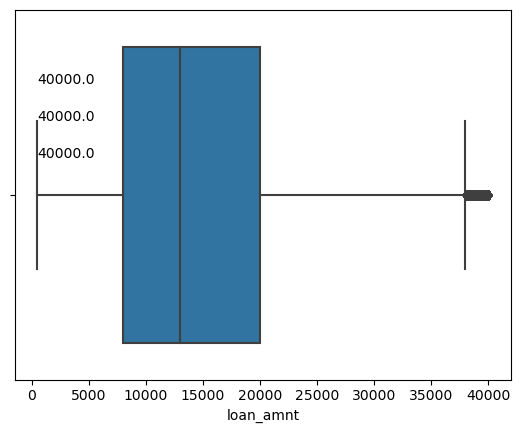

/Users/masad/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


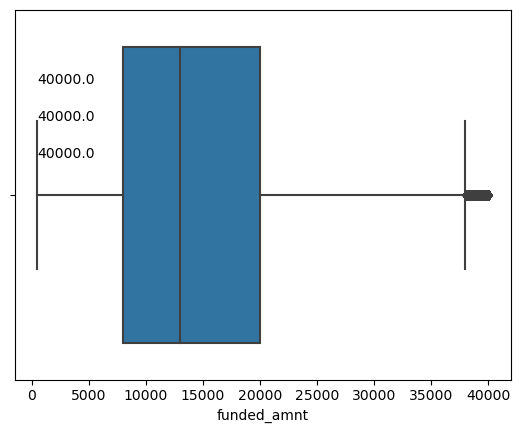

/Users/masad/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


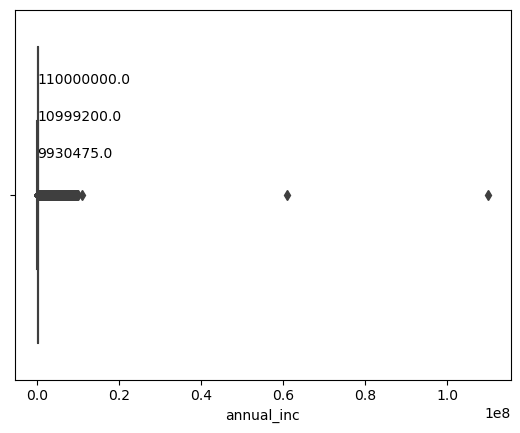

/Users/masad/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


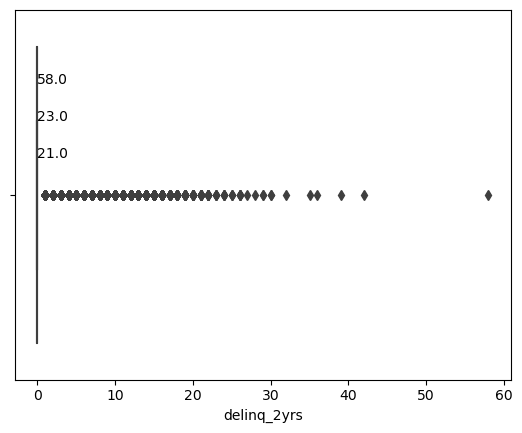

/Users/masad/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


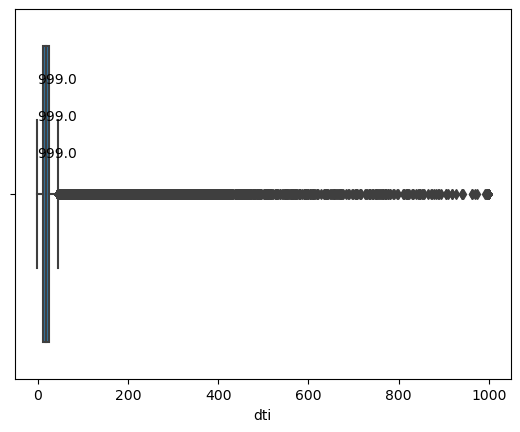

/Users/masad/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


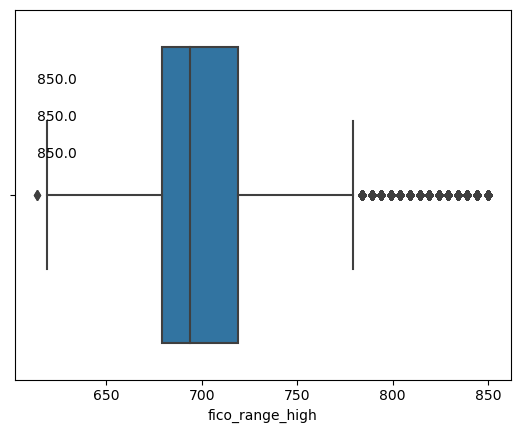

/Users/masad/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


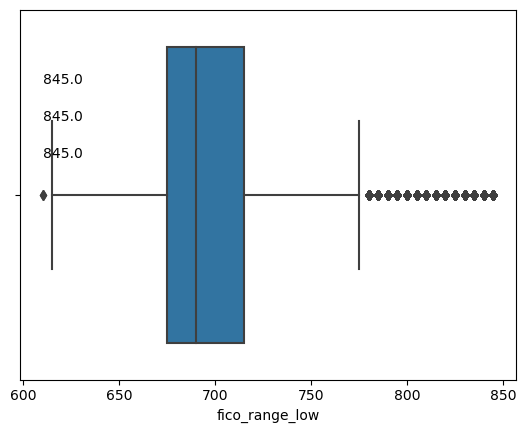

/Users/masad/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


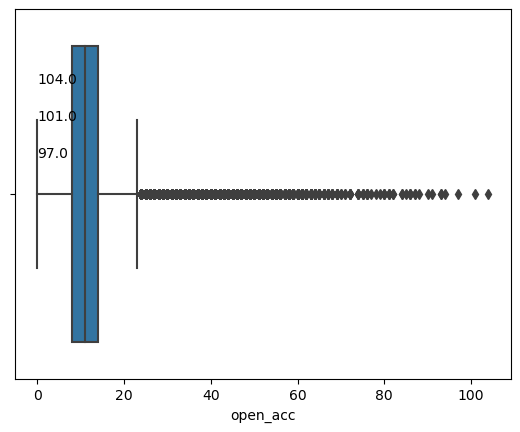

/Users/masad/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


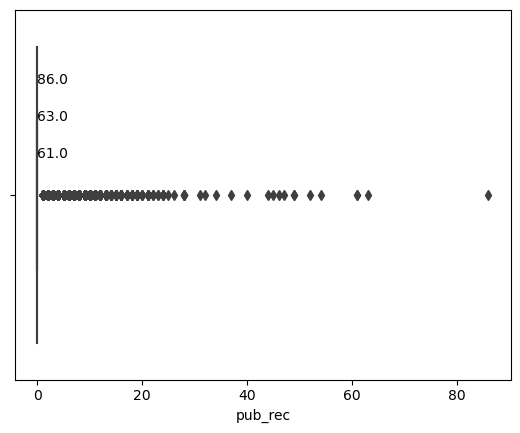

/Users/masad/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


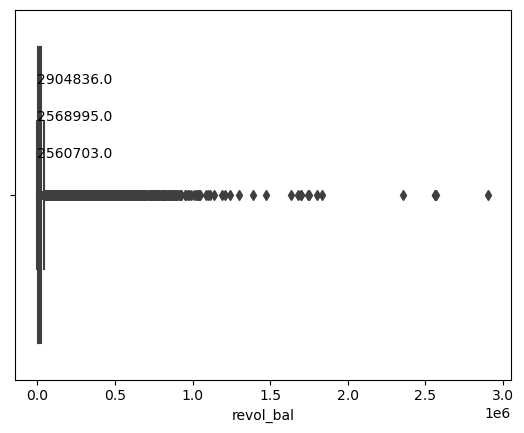

/Users/masad/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


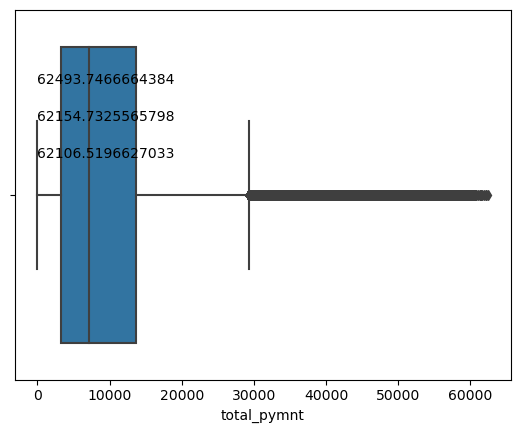

/Users/masad/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


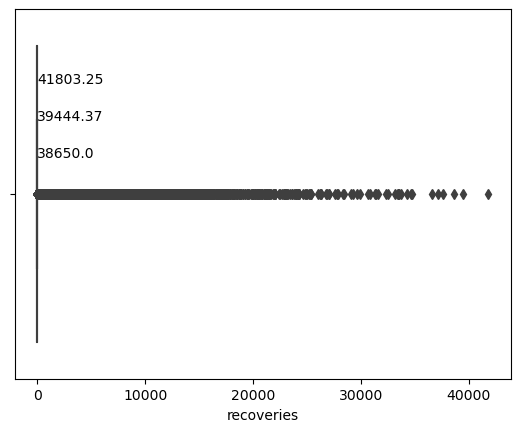

/Users/masad/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


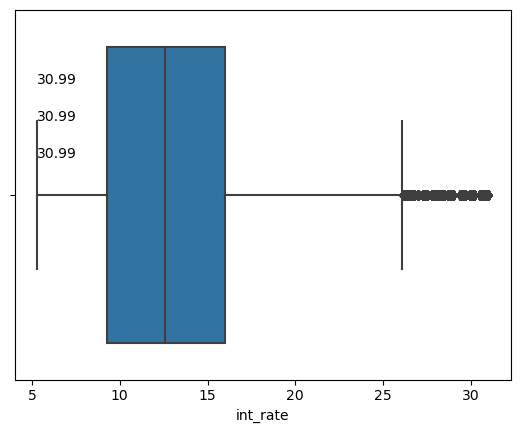

/Users/masad/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


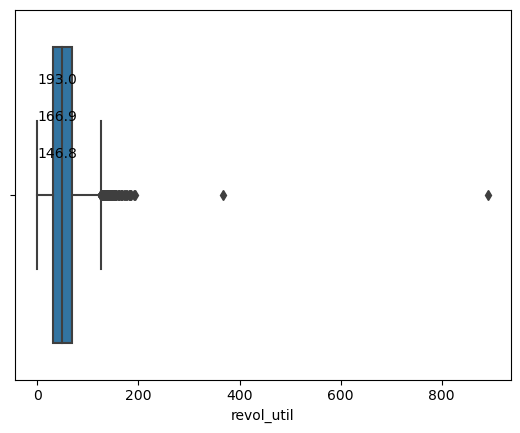

/Users/masad/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


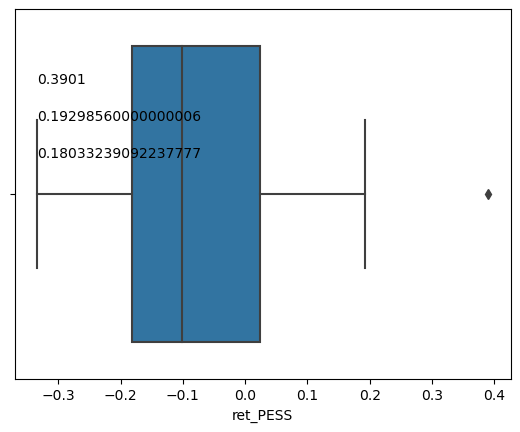

/Users/masad/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


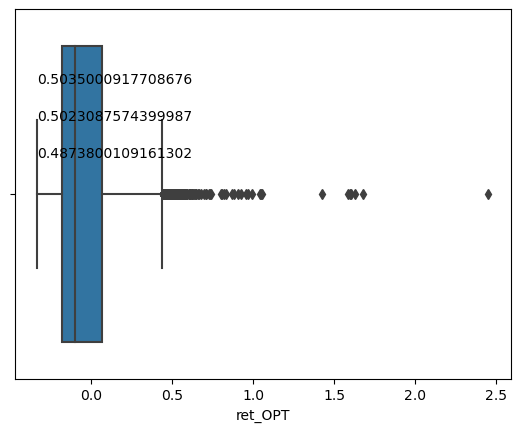

/Users/masad/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


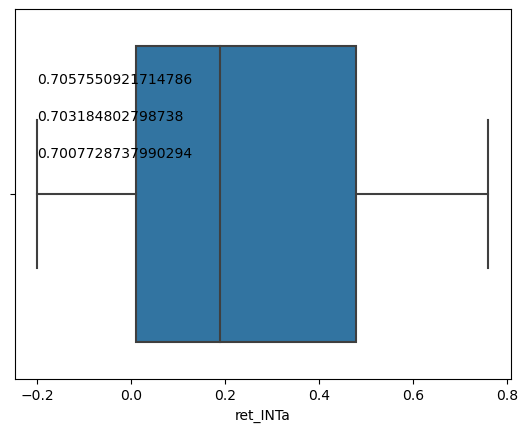

/Users/masad/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


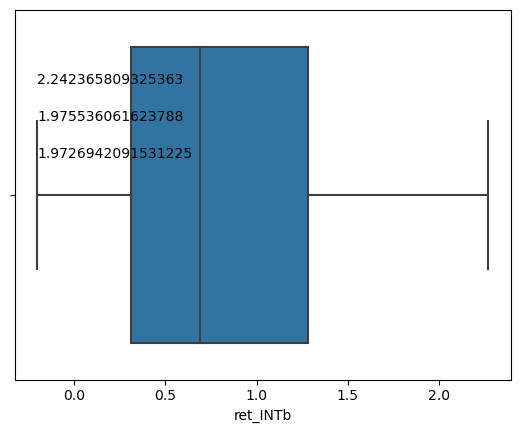

term
2
 36 months    1949756
 60 months     815659
Name: term, dtype: int64


grade
7
B    811304
C    768632
A    596277
D    397211
E    138329
F     41596
G     12066
Name: grade, dtype: int64


home_ownership
6
MORTGAGE    1359007
RENT        1090600
OWN          312178
ANY            3393
OTHER           182
NONE             55
Name: home_ownership, dtype: int64


verification_status
3
Source Verified    1066701
Not Verified        997623
Verified            701091
Name: verification_status, dtype: int64


loan_status
9
Current                                                1559756
Fully Paid                                              901142
Charged Off                                             238095
Late (31-120 days)                                       34060
In Grace Period                                          19614
Late (16-30 days)                                         9054
Does not meet the credit policy. Status:Fully Paid        1988
Default                     

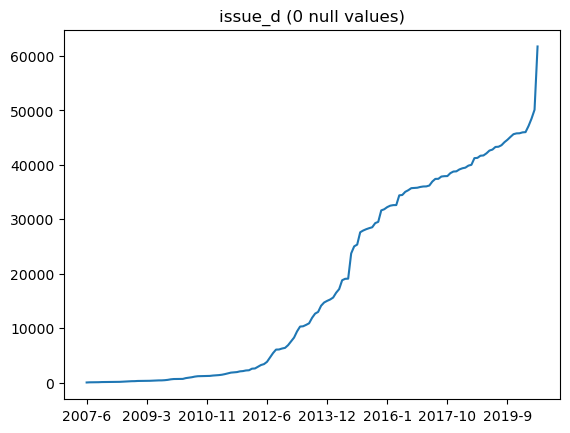

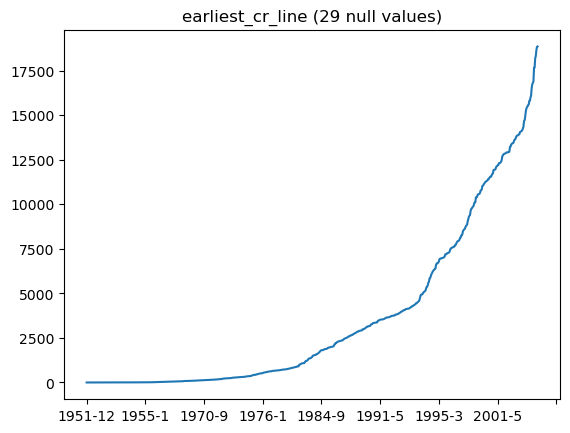

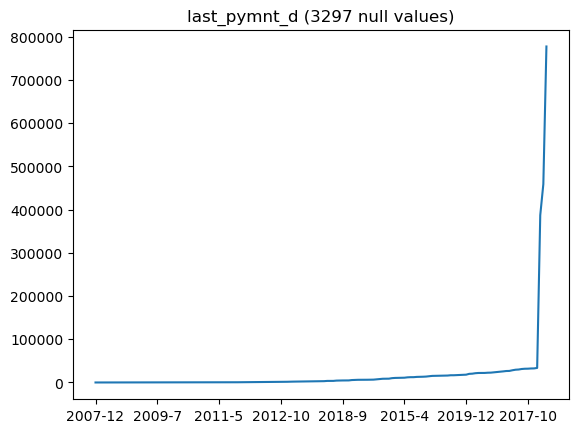

In [27]:
# visualize continuous features
visualize_float_columns()

# visulaize categorical features
visualize_cat_columns()

# visualize date columns
visualize_date_columns()

### Handle outliers

In [28]:
# There are quite a few outliers. 
# Please identify top-k (decide this based on the visualization) features where outliers are most obvious
# top-k features could be loan_amnt, funded_amnt, annual_inc, fico_range_high, fico_range_low, revol_bal, int_rate, revol_util
n_rows = len(final_data)

final_data = final_data[final_data['loan_amnt'] <= 38000] # remove outliers based 1st obvious feature
# remove loan amount larger than 38000

final_data = final_data[final_data['funded_amnt'] <= 38000] # remove outliers based 2nd obvious feature
# remove funded amount larger than 38000

# remove outliers based kth obvious feature
# final_data = final_data[final_data['annual_inc'] <= 20000000] 
# remove annual income larger than 20000000

final_data = final_data[final_data['fico_range_high'] <= 800] 
# remove fico range high larger than 800

final_data = final_data[final_data['fico_range_low'] <= 800] 
# remove fico range low larger than 800

# final_data = final_data[final_data['revol_bal'] <= 1500000] 
# # remove revol balance larger than 1500000

final_data = final_data[final_data['int_rate'] <= 27] 
# remove interest rate larger than 27

final_data = final_data[final_data['revol_util'] <= 140] 
# remove revol util larger than 140

#######changed outlier code for annual inc and revol bal########
top_10_percentile = final_data['annual_inc'].quantile(0.9)
final_data= final_data[final_data['annual_inc'] <= top_10_percentile]
# remove annual income larger than 20000000

top_10_percentile = final_data['revol_bal'].quantile(0.9)
final_data= final_data[final_data['revol_bal'] <= top_10_percentile] 
# remove revol balance larger than 1500000


print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 617454 rows


In [29]:
# Remove all loans that are still current
n_rows = len(final_data)

final_data = final_data[final_data['loan_status']!='Current']

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 1179656 rows


In [30]:
# Only include loans isssued since 2010
n_rows = len(final_data)

final_data = final_data[final_data['issue_d'].dt.year > 2009]

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 6730 rows


### Drop null values

In [31]:
# Deal with null values. We allow cateogrical variables to be null
# OTHER than grade, which is a particularly important categorical.
# All non-categorical variables must be non-null, and we drop
# rows that do not meet this requirement

required_cols = set(cols_to_pick) - set(cat_cols) - set(["id"])
required_cols.add("grade")

n_rows = len(final_data)

# drop rows that contain null based only on "required_cols"
final_data.dropna(subset=list(required_cols),inplace=True,how='any')

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 535 rows


### Visualize clean data

/Users/masad/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


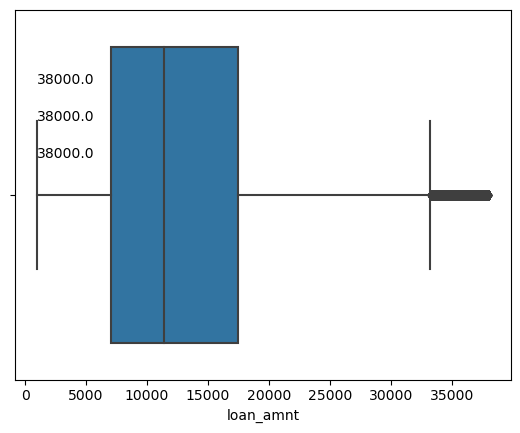

/Users/masad/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


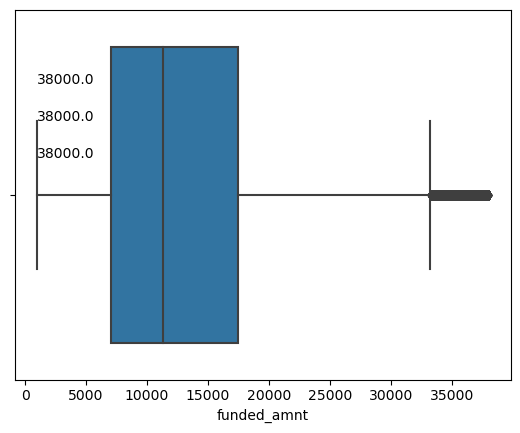

/Users/masad/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


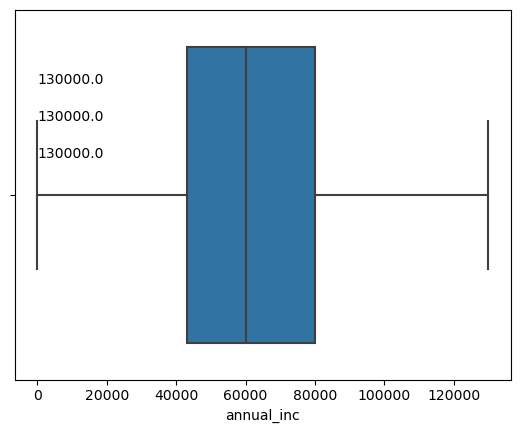

/Users/masad/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


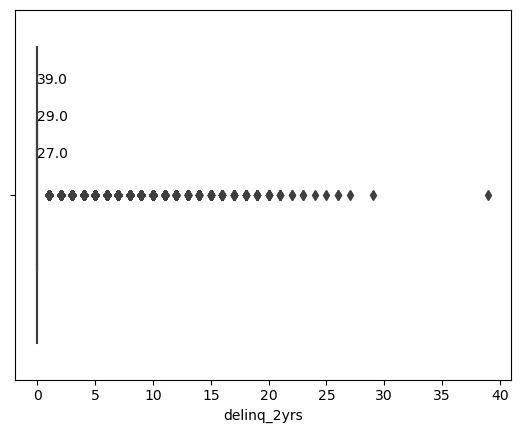

/Users/masad/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


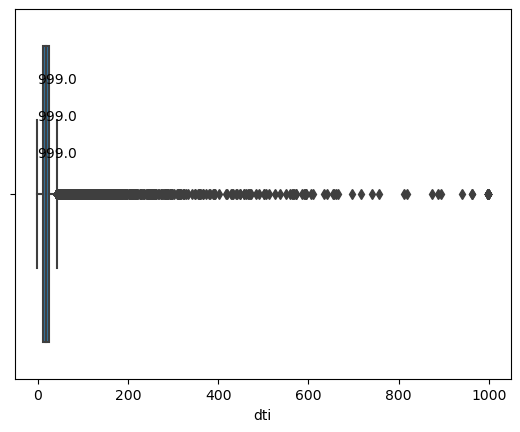

/Users/masad/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


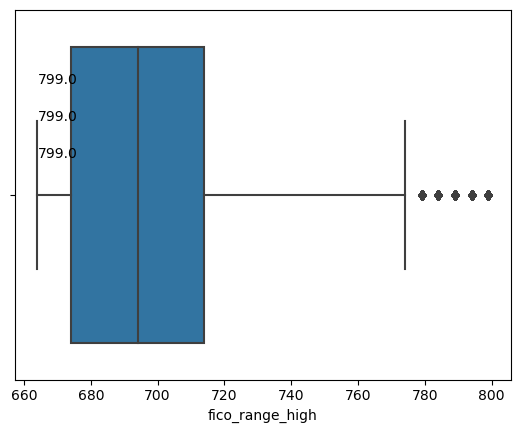

/Users/masad/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


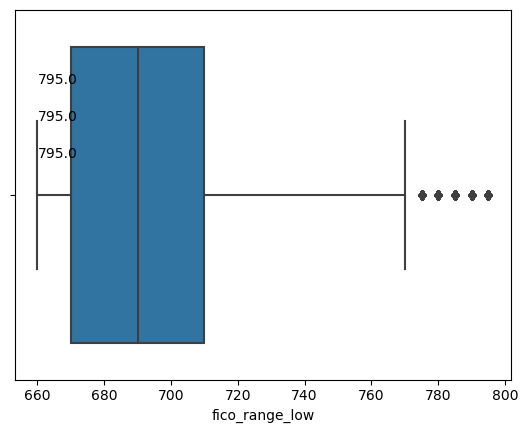

/Users/masad/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


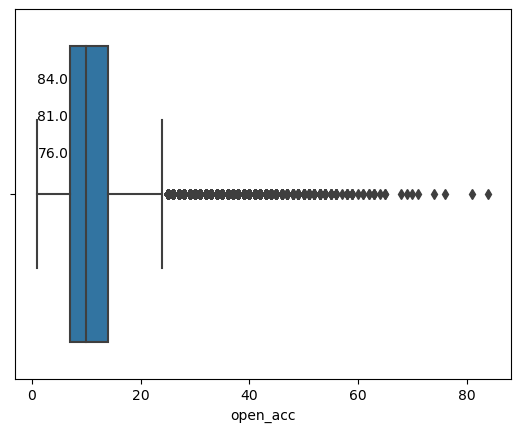

/Users/masad/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


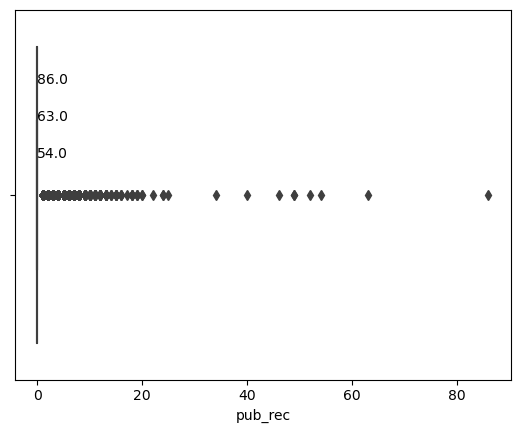

/Users/masad/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


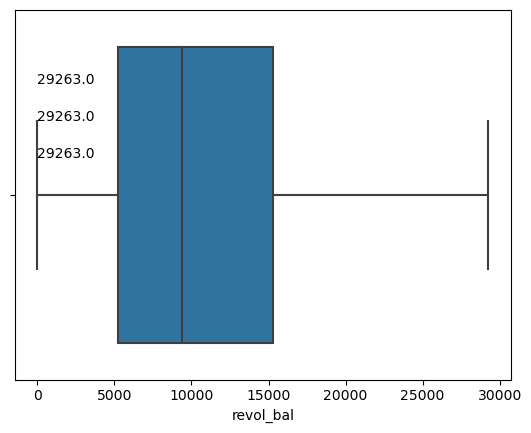

/Users/masad/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


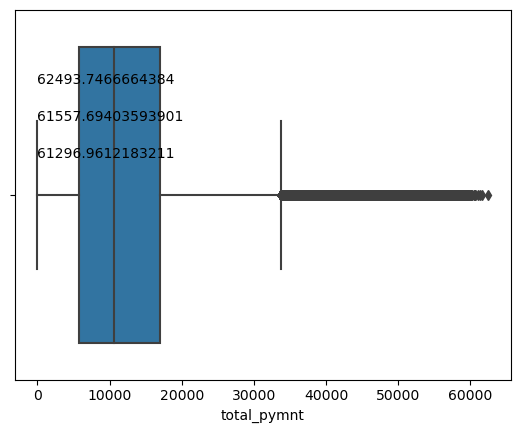

/Users/masad/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


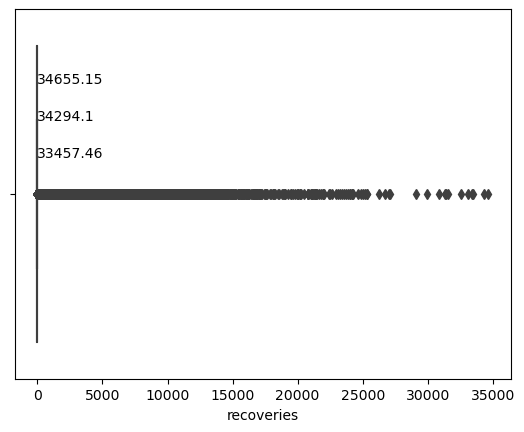

/Users/masad/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


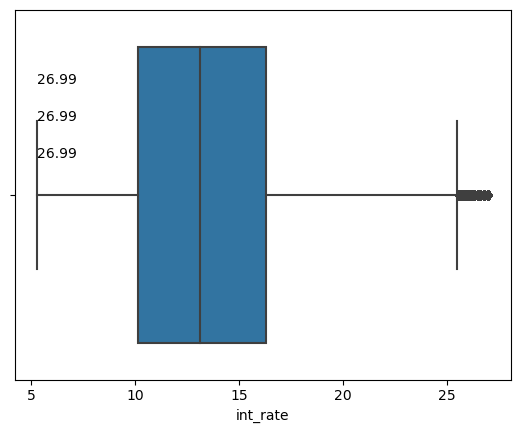

/Users/masad/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


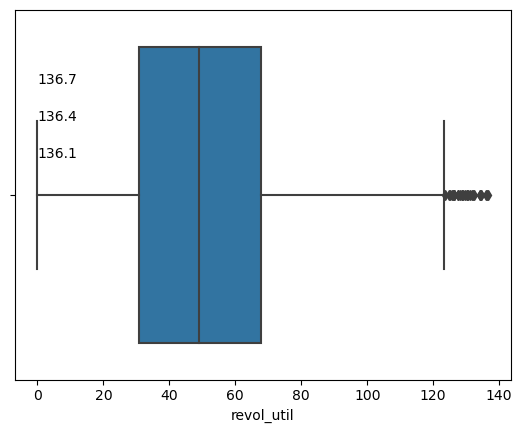

/Users/masad/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


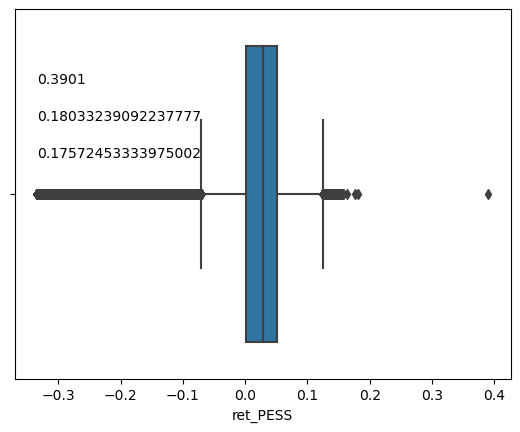

/Users/masad/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


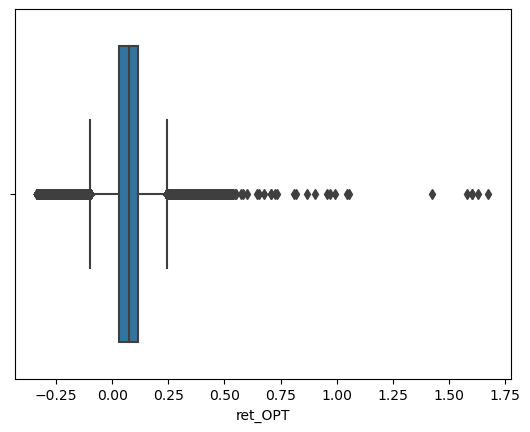

/Users/masad/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


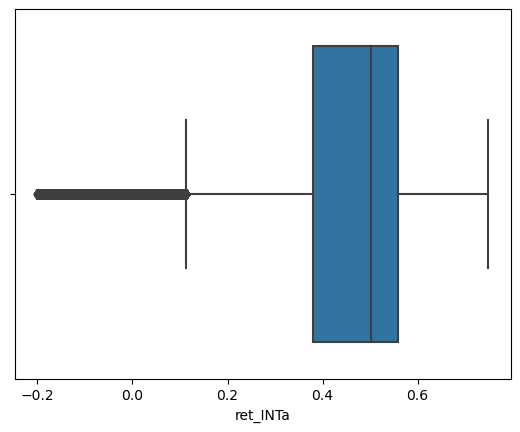

/Users/masad/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


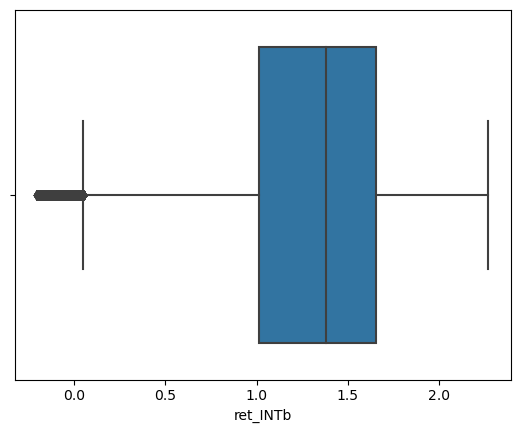

term
2
 36 months    737851
 60 months    223189
Name: term, dtype: int64


grade
7
C    277152
B    276472
D    159872
A    156203
E     68762
F     19513
G      3066
Name: grade, dtype: int64


home_ownership
6
MORTGAGE    437923
RENT        418995
OWN         103428
ANY            613
OTHER           43
NONE            38
Name: home_ownership, dtype: int64


verification_status
3
Source Verified    357911
Not Verified       325946
Verified           277183
Name: verification_status, dtype: int64


loan_status
8
Fully Paid                                             716649
Charged Off                                            194678
Late (31-120 days)                                      26806
In Grace Period                                         14532
Late (16-30 days)                                        6882
Default                                                   734
Does not meet the credit policy. Status:Fully Paid        537
Does not meet the credit policy. Status:Charge

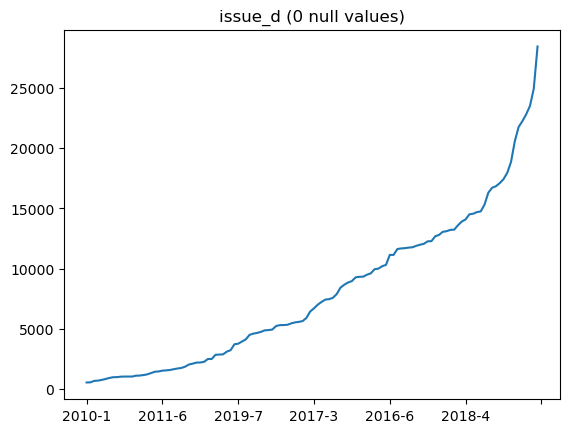

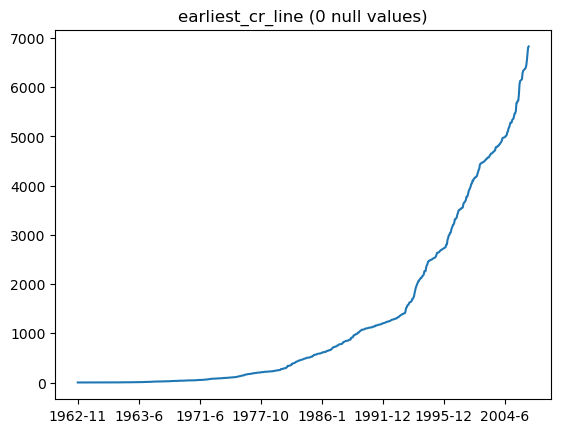

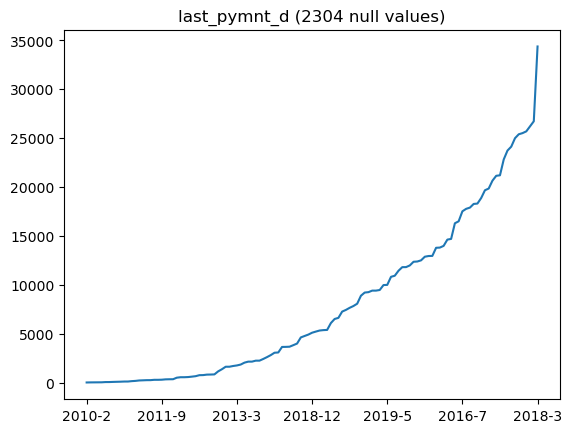

In [32]:
# Visualize the data again after cleaning

# visualize continuous features
visualize_float_columns()

# visulaize categorical features
visualize_cat_columns()

# visualize date columns
visualize_date_columns()

<AxesSubplot:>

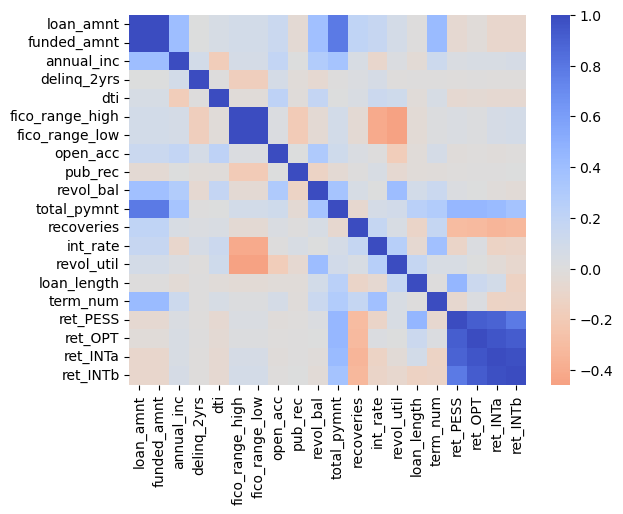

In [33]:
# Visualize the feature correlations
    # You can compute the correlation among features and display a heat-map of the matrix 
    # OR use sns scatter or pairplot
corr = final_data.corr()

center = 0
cmap = seaborn.color_palette("coolwarm", as_cmap=True).reversed()

seaborn.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns, cmap = cmap, center = center)

From the above plot, we can see that the ret_cols are all very correlated. This could be due to the similar inputs that they have used during calculation, and since all of them represent the returns, it is highly possible that they reach to similar conclusion. 

Besides, fico_range_high and fico_range_low are also highly correlated, which is probably because both variables are indicators of FICO score. If the fico_range_high is high, it is possible that fico_range_low is also high. 

Loan amount and funded amount are also highly correlated. This is not too surprising as a higher loan amount applied by the borrower could be associated with the funded amount committed to that loan at the time. 

Similarly interest rate and fico score ranges are inversely related as expected; a higher fico score would have a lower interest rate.

Interestingly enough, term num and int_rate also seem to have a positive correlation. 

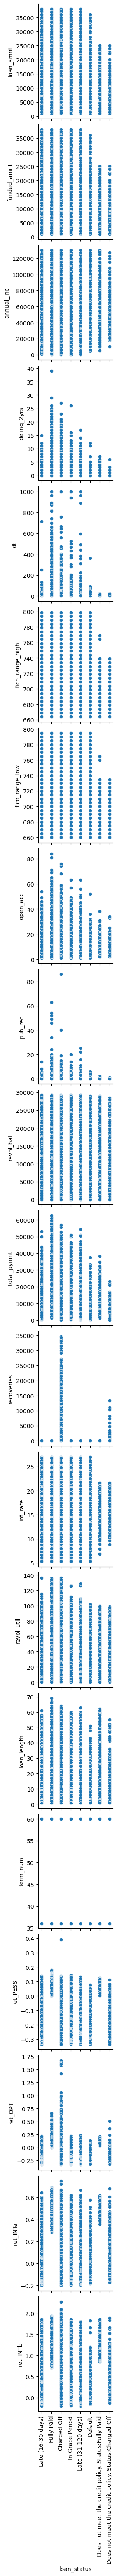

In [34]:
# Visualize relation between loan status and features
# sns pairplot or scatter plot. Refer to recitations


seaborn.pairplot(final_data,x_vars=['loan_status'],height=3, aspect=1.5)
plt.xticks(rotation=90)
plt.show()

What do you observe after removing the outliers?

After removing the outliers, we can see that the data is not scattered that much compared to before. Therefore, the trend / underlying patterns of the features became more obvious, which helps our exploration of data.

A very visible difference, for example, can be seen in the variable annual_inc since previously the distribution of the data was not clear but now we can easily identify it from the whiskers.

As for the correlation between loan_status and the features, there are several interesting results which caught our eyes:
- There seem to be no specific pattern between grade / verification status and loan status, which was quite unexpected.
- People who are more likely to default seems to have a lower annual income as expected.
- The loan length for default loans are shorter compared to others as expected.
- With regards to ret rates calculated, it is noted that the defaults loans tend to have lower rates compared to loans of other status. And for each loan status, the loans demonstrated similar patterns among all for ret rates.
- For ret_variables, we observe that some of the return is negative even when the loan_status is late
- Moreover, the returns have a wider spread when they are classified as charged off as opposed to when paid in full

### Data Exploration
Solution to Q.7 from the handout

In [40]:
# Find the percentage of loans by grade, the default by grade,
# and the return of each grade
perc_by_grade = (final_data.grade.value_counts()*100/len(final_data)).sort_index()

default_by_grade = final_data.groupby("grade").apply(lambda x : (x.loan_status != "Fully Paid").sum()*100/len(x) )
ret_by_grade_OPT = final_data.groupby("grade").mean()['ret_OPT'] # average return for M2-Optimistic for each loan grade
ret_by_grade_PESS = final_data.groupby("grade").mean()['ret_PESS'] # average return for M1-Pessimistic for each loan grade
ret_by_grade_INTa = final_data.groupby("grade").mean()['ret_INTa'] # average return for M3
ret_by_grade_INTb = final_data.groupby("grade").mean()['ret_INTb'] # average return for M3
int_rate_by_grade = final_data.groupby("grade").mean()['int_rate'] # average interest rate for each grade

combined = pd.DataFrame(perc_by_grade)
combined.columns = ['perc_of_loans']
combined['perc_default'] = default_by_grade
combined['avg_int_rate'] = int_rate_by_grade
combined['return_OPT'] = ret_by_grade_OPT
combined['return_PESS'] = ret_by_grade_PESS
combined['return_INTa'] = ret_by_grade_INTa
combined['return_INTb'] = ret_by_grade_INTb

combined

,perc_of_loans,perc_default,avg_int_rate,return_OPT,return_PESS,return_INTa,return_INTb
A,16.253538,9.463967,7.278671,0.033715,0.006263,0.444798,1.314466
B,28.768001,17.776845,10.909618,0.041269,0.003373,0.433740,1.282238
C,28.838758,28.528750,14.231999,0.039542,-0.010046,0.409479,1.232789
D,16.635312,37.269816,18.031800,0.040467,-0.018781,0.387861,1.183098
E,7.154957,44.549315,21.245906,0.045813,-0.021390,0.373178,1.142962
F,2.030405,49.264593,23.938444,0.053503,-0.013483,0.373956,1.126791
G,0.319029,50.945858,25.457544,0.066987,-0.005671,0.388068,1.148947


Based on the output of previous cell, write down your answers to Q.7 from the handout.

### Save a Pickle

In [41]:
# Remove the "total_pymnt" and "recoveries" from the list of continuous features
continuous_features.remove('total_pymnt')
continuous_features.remove('recoveries')

Why did we remove `total_pymt` and `recoveries` from the data for the task of predicting whether to give loan or not, although these are highly predictive features?

In [44]:
# save the prepared data for modeling in next Phase.
pickle.dump( [final_data, discrete_features, continuous_features, ret_cols], open(pickle_file, "wb") )